# Representation learning with Doc2Vec

Practical course material for the ASDM Class 09 (Text Mining) by Florian Leitner.

© 2017 Florian Leitner. All rights reserved.

## Introduction

In addition to word embeddings we just saw, it is possible to aggregate the word embeddings and combine them with a document-specific inference step to produce [Le and Mikolov (2014)](https://cs.stanford.edu/~quocle/paragraph_vector.pdf)'s approach for producing document embeddings, called *paragraph vectors*, aka. "Doc2Vec" (in analogy to "Word2Vec").

The only requirement for this notebook is `gensim` and NTLK for the [Reuters-21578 corpus](https://archive.ics.uci.edu/ml/datasets/Reuters-21578+Text+Categorization+Collection).
And we will be following a heavily modified version of `gensim`'s [Doc2Vec tutorial](https://nbviewer.jupyter.org/github/RaRe-Technologies/gensim/blob/develop/docs/notebooks/doc2vec-lee.ipynb).

In [1]:
import gensim
import os
import nltk

# show text as HTML
from IPython.display import HTML
%pylab inline --no-import-all

Populating the interactive namespace from numpy and matplotlib


In [2]:
nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

## Corpus preparation: Reuters-21578

We will be using the same corpus we had in use for clustering, this time including the test data, too.

In [3]:
from nltk.corpus import reuters 

If the above step didn't work, first download the Reuters corpus from the GUI that pops up here:

In [3]:
#nltk.download()

Here's a sample document:

In [4]:
HTML(reuters.raw(reuters.fileids()[0])[:200] + "...")

The around 12,000 Reuters news articles in this corpus (the "ApteMod" corpus version) are assigned to the following categories:

In [5]:
print("all", len(reuters.categories()), "categories:")
HTML(", ".join(reuters.categories()))

all 90 categories:


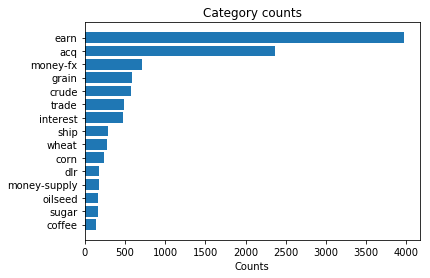

In [6]:
pairs = sorted([
    (len(reuters.fileids(cat)), cat)
    for cat in reuters.categories()
])

counts = [cnt for cnt, cat in pairs[-15:]]
cats = [cat for cnt, cat in pairs[-15:]]
plt.barh(range(len(cats)), counts)
plt.yticks(range(len(cats)), cats)
plt.xlabel('Counts')
plt.title('Category counts')
plt.show()

Let's calculate the mean number of categories per document:

In [8]:
n_cat_sum = sum(len(reuters.categories(doc_id))
                for doc_id in reuters.fileids())
n_docs = len(reuters.fileids())
print("mean n. categories/document = {:.3f}".format(
    n_cat_sum / n_docs))

mean n. categories/document = 1.235


Finally, we go through the usual preprocessing setup we've seen these days already: tokenization, removing accents, removing stopwords and tokens with two or less characters, lemmatization of tokens, and forming bigram collocations.

In [9]:
from gensim.models.doc2vec import TaggedDocument
from gensim.utils import simple_preprocess
from gensim.models import Phrases
from gensim.models.phrases import Phraser
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

stopwords_en = (frozenset(stopwords.words('english'))
                | frozenset(["also"]))
lemmatizer = WordNetLemmatizer()
lemmatize = lambda t: lemmatizer.lemmatize(t, pos='v')

def read_and_tokenize(doc_id):
    doc = reuters.raw(doc_id)
    # strip accents and tokens with less than 3 characters
    # NB: implicitly removes tokens *longer* than 15 characters
    return simple_preprocess(doc, deacc=True, min_len=3)

train_corpus = []
test_corpus = []

for doc_id in reuters.fileids():
    doc = TaggedDocument(
        simple_preprocess(reuters.raw(doc_id),
                          deacc=True, min_len=3),
        [doc_id])

    if doc_id.startswith("train"):
        train_corpus.append(doc)
    else:
        test_corpus.append(doc)

words = [d.words for d in train_corpus]
collocations = Phraser(Phrases(words))

def preprocess(doc):
    """
    Stopword filtering,
    collocation detection (joining),
    and token lemmatization.
    """
    
    doc_filtered = filter(lambda w: w not in stopwords_en,
                          doc.words)
    doc_colloc = collocations[doc_filtered]
    doc_lemmas = [lemmatize(token) for token in doc_colloc]
    return TaggedDocument(doc_lemmas, doc.tags)

train_corpus = [preprocess(d) for d in train_corpus]
test_corpus = [preprocess(d) for d in test_corpus]

print("n. train docs:", len(train_corpus))
print("n. test docs:", len(test_corpus))

n. train docs: 7769
n. test docs: 3019


In [10]:
print("training/1 tags :", train_corpus[0].tags)
print("training/1 words:")
HTML(" ".join(train_corpus[0].words[:50]) + "...")

training/1 tags : ['training/1']
training/1 words:


Note that the number of `tags` must be constant across all documents for Doc2Vec to work.
And recall from the theory that `tags` is *not* a label, rather, its just an arbitrary, but unique (paragraph) ID for each document used during training (see Figures 2 and 3 in the Le & Mikolov paper).

## Model training

Gensim provides Le's paragraph vectors via its [Doc2Vec API](https://radimrehurek.com/gensim/models/doc2vec.html#gensim.models.doc2vec.Doc2Vec), which is based on the earlier Word2Vec API; It can be used to train the word embeddings at the same time (as the document embeddings).

In [12]:
from gensim.models.doc2vec import Doc2Vec

model = Doc2Vec(
    workers=4, # CPU cores, "t" (threads)
    iter=10, # epochs; 
    # typically, use more than Word2Vec (5-30)
    # -> increase iter until the consistency evaluation "works"
    alpha=0.025, # learning rate 
    # might optimize this (0.5-0.001)
    # -> related with iter/epochs changes; fine-tuning
    size=len(reuters.categories()) // 2, # n. dim. 
    # -> optimize this (30-3000)
    hs=0, negative=20, # use "hs" (1) or "s" (>0, range: 2-30)
    # hs = hierarch. softmax
    # s = neg. subsampling (rate)
    window=5, # typically 5, might be optimized (2-30)
    min_count=2, # min. freq. to add token to model
    # filter junk and "hard-to-learn" words (1-10ish)
    # -> a "light" regularization parameter
    dm=0, dbow_words=1 # train with DM or DBOW (and W2V) model
)
# add the training documents
model.build_vocab(train_corpus)
print(model)
# Doc2Vec(model,dimensions,....,threads)
model.dm, model.dbow, model.sg
# True 0 0 -> DM model
# False 1 1 -> DBOW model (and words)

Doc2Vec(dbow+w,d45,n20,w5,mc2,s0.001,t4)


(False, 1, 1)

For example, the count for the word "executive" in the corpus is:

In [13]:
model.wv.vocab['executive'].count

54

Traing should happen pretty fast - less than one minute on my quad-core machine.

In [14]:
%%time
model.train(
    train_corpus,
    total_examples=model.corpus_count,
    epochs=model.iter)

CPU times: user 1min 47s, sys: 394 ms, total: 1min 47s
Wall time: 27.3 s


4851324

## Document inference

With this model in place, you can now build new document embedding vectors for an unseen document:

In [15]:
model.infer_vector([
    'a', 'trivial', 'sample', 'document',
    'to', 'infer', 'an', 'embedding'
])

array([-0.45949781,  0.05013795, -0.50757664, -0.18050912,  0.02658268,
        0.27198178, -0.41617486, -0.29049665,  0.28125477, -0.50475585,
       -0.09590899,  0.18044834,  0.00961993,  0.00209527,  0.50641751,
       -0.19694327,  0.69898385, -0.29305515, -0.3271215 ,  0.10161357,
        0.31647757,  0.53769004,  0.27872261, -0.43017522, -0.21492016,
       -0.21783571,  0.40026492,  0.0870956 ,  0.15500104,  0.25074407,
        0.35743505,  0.44467661, -0.24711996, -0.25583658, -0.26881629,
       -0.24515086,  0.28306478,  0.46773168,  0.36428374,  0.23417291,
       -0.09876581, -0.50789618, -0.25526094, -0.03906316,  0.09192097], dtype=float32)

Note that each inference run produces slightly different results due to random sampling of the paragraph words (see the Le & Miklolov paper). Verify this by re-running the above cell.

## Model consistency check

A simple way to assess the embeddings and the inference makes any sense at all is to self-test the model: That is, by infereing document vectors for each training set document, and verifying that the most similar document is the same as the input document using [`DocvecsArray.most_similar`](https://radimrehurek.com/gensim/models/doc2vec.html#gensim.models.doc2vec.DocvecsArray.most_similar).

For example:

In [16]:
model.docvecs.most_similar([
    model.infer_vector([
        'a', 'trivial', 'sample', 'document',
        'to', 'infer', 'an', 'embedding'
    ])
])

[('training/14709', 0.9256892204284668),
 ('training/5362', 0.9256457686424255),
 ('training/12371', 0.9230365753173828),
 ('training/13158', 0.9217793345451355),
 ('training/14682', 0.9215726852416992),
 ('training/13272', 0.9206629991531372),
 ('training/14686', 0.9196255803108215),
 ('training/1143', 0.9189420938491821),
 ('training/1758', 0.9172046780586243),
 ('training/14701', 0.9167390465736389)]

Now, lets run this over all documents and see where we stand; Because we must re-run the inference for each document, and then need to compare the simlilarity of the inferred vector against all known vectors, this might take a bit. To make this faster, we'll just check 10% of our documents.

In [17]:
from random import sample

n_docs = len(train_corpus)
n_trials = n_docs // 10
ranks = [0] * n_docs
similarty_sum = 0.
# alias (save screen width)
most_similar = model.docvecs.most_similar

for doc in sample(train_corpus, n_trials):
    inferred_vector = model.infer_vector(doc.words)
    sims = most_similar([inferred_vector], topn=n_docs)
    doc_ids = [doc_id for doc_id, sim in sims]
    rank = doc_ids.index(doc.tags[0])
    ranks[rank] += 1
    similarty_sum += sims[rank][1]
    
for rank, count in enumerate(ranks[:5], 1):
    if count > 0:
        print("rank", rank, "document matched observed", count,
              "times ({:.1f}%)".format(100 * count / n_trials))

print("\nremaining ranks observed {:d} times ({:.1f}%)".format(
    sum(ranks[5:]),
    100 * sum(ranks[5:]) / n_trials))
print("mean similiarity score = {:.3f}".format(
    similarty_sum / n_trials))

rank 1 document matched observed 709 times (91.4%)
rank 2 document matched observed 30 times (3.9%)
rank 3 document matched observed 6 times (0.8%)
rank 4 document matched observed 4 times (0.5%)
rank 5 document matched observed 4 times (0.5%)

remaining ranks observed 23 times (3.0%)
mean similiarity score = 0.957


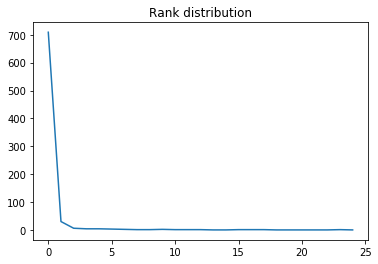

In [18]:
plt.plot(list(range(25)), ranks[:25])
plt.title('Rank distribution')
plt.show()

Note that your results will differ on each run of the above cell due to the random sampling and also because the model isn't very good due to the tiny corpus size. But you should observe a large mean (Cosine vector) similarity, like 0.8, and ideally above 0.9, and there should be a significant "mass" of documents that are matched with rank 1 (80% or more).

## Model evaluation

Next, lets use the following tactic to evaluate our model: How many of the categories of the query (i.e., test) document match with the best-matching indexed (i.e., train) document? You could use this, for example, to evaluate adding documents to category-specific clusters, or a nearest neighbor-like apporach for predicting document categories.

In [19]:
similarties = []
n_docs = len(test_corpus)
hits = 0
pred_cats = 0
ann_cats = 0
# alias (save screen width)
most_similar = model.docvecs.most_similar

for doc in test_corpus:
    test_id = doc.tags[0]
    test_cats = set(reuters.categories(test_id))
    
    inferred_vector = model.infer_vector(doc.words)
    
    match_id, sim = most_similar([inferred_vector], topn=1)[0]
    match_cats = set(reuters.categories(match_id))
    
    similarties.append(sim)
    hits += len(test_cats & match_cats)
    pred_cats += len(test_cats)
    ann_cats += len(match_cats)

similarties = sorted(similarties)

print("Precision: {:d}/{:d} = {:.2f}%".format(
    hits, pred_cats,
    100 * hits / pred_cats))
print("Recall   : {:d}/{:d} = {:.2f}%\n".format(
    hits, ann_cats,
    100 * hits / ann_cats))
print("mean   similiarity score = {:.3f}".format(
    sum(similarties) / n_docs))
print("median similiarity score = {:.3f}".format(
    similarties[n_docs//2]))

Precision: 2836/3744 = 75.75%
Recall   : 2836/3706 = 76.52%

mean   similiarity score = 0.874
median similiarity score = 0.877


Step back a moment and let this sink in: We've achieved a category prediction performance that maybe does not (yet) beat the supervised methods we looked into on day one. Without ever conditioning the model on the categories, we've achieved a result that is far beyond random predictions (Reuters-21578 has 90 categories). That is, the paragraph vector model figured out the documents' semantics all on its own, and we never told it anything about the categories, yet it clearly is able to make sensible matches, retrieving documents from the same categories.

Our above evaluation setup resembles that of a traditional nearest neighbor classifier. For reference, the highest score a (heavily optimized) kNN classifier ever achieved on this dataset is a [86% micro-averaged $F_1$-score](https://www.aaai.org/Papers/ICML/2003/ICML03-063.pdf) (see Figure 2). But the best kNN classifier used 2000 features, while our model only has 45 dimensions (i.e., features), those feature vectors are generated fully **unsupervised**, and they can be used to train (supervised) classifiers (see the Le & Mikolov paper, where they evaluated paragraph vectors feeding a logistic regression classifier on various datasets and tasks).

In [20]:
# document IDs labeled "earn" that start with "test/"
hits = sum(1 for f in reuters.fileids("earn")
           if f.startswith("test/"))

test_docs = [f for f in reuters.fileids()
             if f.startswith("test/")]

# n. labels on of test documents
n_cats = sum(len(reuters.categories(f)) for f in test_docs)

print("Basline precision (predict earn always): {:.1f}%".format(
    100 * hits / len(test_docs)))

print("Basline recall    (predict earn always): {:.1f}%".format(
    100 * hits / n_cats))

Basline precision (predict earn always): 36.0%
Basline recall    (predict earn always): 29.0%


Note that the Reuters categories are highly imbalanced, and just predicting the majority label (`earn`) gives you a 32% micro-averaged $F_1$ on this set (i.e., the best "test dummy" baseline, maybe).

## Conclusions

Finally we have arrived at the "core" of statistical text mining: we can now easily convert a document into small-ish (< 1000) arrays of numbers. And we've emulated supervised models using only "represenation learning" techniques that are fully unsupervised. It should go without saying that even more impressive results can be achieved by combining the two approaches: first, use representation learning to create document vectors and then use supervised learning to predict the correct label(s), using the document vectors as input (instead of the noisy, sparse bag-of-word vectors).